# Statistical bias correction for satellite precipitation in British Columbia - an application of Gaussian process regression

<p style="text-align: center;">
Yingkai Sha
</p>
<p style="text-align: center;">
Earth, Ocean and Atmospheric Sciences, University of British Columbia
</p>

**General steps:**
* Process gridded GPM data in Nov 21st 2017 (`3B-HHR.MS.MRG.3IMERG`)
* Process BC Hydro in-situ observations (daily precip)
* Calculate the additive bias between in-situ obs and GPM (the closest GPM grid at station location).
* Split station data (bias and obs) into train/test groups
* Configure GPR (lat/lon --> bias) and learn hyper-parameters through training set (at station locations)
* Apply GPR to produce bias for all GPM grids, and use gridded bias for GPM correction
* Compare the corrected GPM with testing set, report metrics

In [1]:
# import modules
import GPy
import time
import numpy as np
from scipy import stats
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
# import plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# KDTree function
def KDTree_wraper(dist_lon, dist_lat):
    '''
    A warper of scipy.spatial.cKDTree
    Tree = KDTree_wraper(dist_lon, dist_lat)
    '''
    return cKDTree(list(zip(dist_lon.ravel(), dist_lat.ravel())))

# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

% matplotlib inline

In [2]:
B = [0.5, 0.5, 1] # color

# Data 

In [3]:
# Preprocessed GPM data
temp = np.load('/Users/yingkai/Repository/WRFT/_data/Satellite/GPM/GPM_BC_Nov_2017.npy')
lon = temp[()]['lon']
lat = temp[()]['lat']
GPM = temp[()]['GPM'][20, ...]
ERROR = temp[()]['ERROR'][20, ...]
TOPO = temp[()]['TOPO'] # TOPO for plotting
ocean_flag = TOPO<0 # flag out ocean
# BC Hydro station observation
temp = np.load('/Users/yingkai/Repository/WRFT/_data/Satellite/GPM/BCH_obs_Nov_2017.npy')
stn_lon = temp[()]['stn_lon']
stn_lat = temp[()]['stn_lat']
stn_obs = temp[()]['stn_obs']
stn_code = np.array(temp[()]['stn_code'])
# train/test split: 20 data poiunts for test
# ===== #
# For reproducing the result, here the "random" is hard coded. Cannon use seed because of the Monte Carlo later. 
## withhold = sorted(np.random.randint(len(stn_lon), size=20)) # <--- original version
stn_test_temp = ['ALU', 'BRI', 'COX', 'DAI', 'DOW', 'ERC', 'FDL', 'FST', 'HEB', 'HFF', \
                 'MSK', 'PNK', 'PYN', 'STV', 'WOL', 'YPW', 'YXJ', 'YZY']
withhold = []
for test_code in stn_test_temp:
    withhold.append(np.where(stn_code==test_code))
# ==== #
withhold_flag = np.in1d(np.arange(len(stn_lon)).astype(int), withhold)
# test
test_lon = stn_lon[withhold_flag]
test_lat = stn_lat[withhold_flag]
test_obs = stn_obs[withhold_flag]
test_code = np.array(stn_code)[withhold_flag]
# train
train_lon = stn_lon[~withhold_flag]
train_lat = stn_lat[~withhold_flag]
train_obs = stn_obs[~withhold_flag]
train_code = np.array(stn_code)[~withhold_flag]
# identify the closest GPM grid for each station
gridTree = KDTree_wraper(lon, lat)
grid_shape = lat.shape
_, inds = gridTree.query(list(zip(stn_lon, stn_lat)))
stn_indx, stn_indy = np.unravel_index(inds, grid_shape)
test_indx = stn_indx[withhold_flag]
test_indy = stn_indy[withhold_flag]
train_indx = stn_indx[~withhold_flag]
train_indy = stn_indy[~withhold_flag]
train_GPM = GPM[train_indx, train_indy]
#train_elev = TOPO[train_indx, train_indy] # elevation as an optional input (not used as default)

In [4]:
# ERROR = the "uncertainty" in GPM retrieval 
train_ERROR = ERROR[train_indx, train_indy]
test_ERROR = ERROR[test_indx, test_indy]

In [5]:
# an example of errors at training stations (see the strong heteroscedasticity)
train_ERROR

array([ 2.69829655,  1.51167774,  8.04047489,  1.29551387, 66.98272705,
        8.09943581,  0.82486361,  8.61532974,  4.77709913,  0.82486361,
        3.97429633,  0.82486361,  3.37877679,  9.41085529,  6.14507866,
        6.84639502,  2.7813766 ,  1.6680162 ,  7.26095819,  8.39840031,
        0.98796833,  2.12111855,  2.12111855,  2.38613963, 17.80246735,
        0.82486361, 14.65445042,  6.98858023,  6.98858023,  0.82486361,
        0.96742344,  2.24190116,  4.16008377, 13.21165466,  3.32076311,
        0.82486361,  0.82486361,  0.82486361,  0.82486361,  1.2289145 ,
        0.82486361, 27.44577789,  1.91780579,  0.82486361,  0.82486361,
        4.22255993,  1.38956285,  0.82486361,  0.82486361,  9.40810299,
        0.82486361,  0.82486361,  0.82486361,  0.82486361,  3.52927518,
        0.82486361,  0.82486361,  2.88959408,  5.62971973,  1.97055507,
        0.82486361,  1.9074204 ,  1.38956285,  1.67006695,  1.60449731,
        6.35011625,  0.93439996, 22.2326355 ,  0.82486361,  8.55

In [10]:
# Station plot is not showing here

# GPR model

In [6]:
# lat/lon as input features
GRID = np.vstack([train_lon, train_lat]).T # shape=(stn_num, 3)
# in-situ obs minus GPM (additive bias) as target
Y = (train_obs-train_GPM)[:, None]

**Configuration**

In [87]:
# GPR configuration:
## zero-mean
## isotropic RBF + anisotropic Matern32 + heteroscedasticity defined by GPM error
## GPM error fixed

kernel = GPy.kern.RBF(input_dim=1, ARD=True)*GPy.kern.Matern32(input_dim=2, ARD=True) + \
         GPy.kern.White(input_dim=1)
# set priors
model = GPy.models.GPHeteroscedasticRegression(GRID, Y, kernel)
model['.*het_Gauss.variance'] = train_ERROR[:, None]**2; model.het_Gauss.variance.fix() # <--- fixed
model['sum.mul.rbf.lengthscale'] = 400 # prior can change, leads to different results
#model['sum.mul.Mat32.lengthscale'] = #
# # ===== #
# # MLE optimization for hyper-parameters. Loop over untill converge
# # Replaced by HMC
# status = 'test'
# while status != 'Converged':
#     out = model.optimize(messages=True)
#     status = out.status
# # ===== #

**HMC hyper-param learning**

In [92]:
# Hybrid Monte Carlo, momentum of random walk set as 0.025 (adjusted by hand), Markov Chain sample num set as 50000 
start = time.time() # roughly 25 min
hmc = GPy.inference.mcmc.HMC(model, stepsize=2.5e-2) # stepsize sensitive 
s = hmc.sample(num_samples=20000)
end = time.time()
print('HMC wall time: {} sec'.format(end - start))

 /Users/yingkai/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


HMC wall time: 1387.078467130661 sec


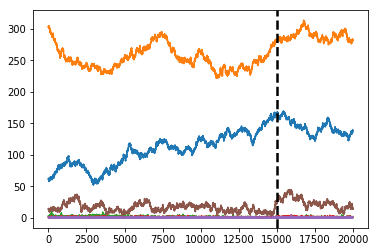

In [94]:
# 15000-20000 is confirmed to be the range that all hyper-params are stable
plt.plot(s)
plt.axvline(x=15000, ls='--', lw=2.5, c='k')
#plt.axvline(x=20000, ls='--', lw=2.5, c='k')

In [95]:
# update paramters into the GPR model

model.sum.mul.rbf.variance = s[-15000:, 0].mean()
model.sum.mul.rbf.lengthscale = s[-15000:, 1].mean()
model.sum.mul.Mat32.variance = s[-15000:, 2].mean()
model.sum.mul.Mat32.lengthscale = s[-15000:, 3:5].mean(axis=0)
model.sum.white.variance = s[-15000:, 5].mean()
#model.Gaussian_noise.variance = s[-10000:, 6].mean()

In [96]:
# export std
s[-15000:, :].std(axis=0)

array([18.19546728, 21.88451348,  0.62351558,  0.48633018,  0.25776405,
        7.82746406])

In [97]:
model

gp.,value,constraints,priors
sum.mul.rbf.variance,129.21478995238706,+ve,
sum.mul.rbf.lengthscale,265.922999104829,+ve,
sum.mul.Mat32.variance,1.521047696899406,+ve,
sum.mul.Mat32.lengthscale,"(2,)",+ve,
sum.white.variance,18.548261964917984,+ve,
het_Gauss.variance,"(86, 1)",+ve fixed,


In [98]:
model.sum.mul.Mat32.lengthscale

index,gp.sum.mul.Mat32.lengthscale,constraints,priors
[0],1.52755529,+ve,
[1],0.72096958,+ve,


In [99]:
model.sum.mul.rbf.lengthscale

index,gp.sum.mul.rbf.lengthscale,constraints,priors
[0],265.92299910,+ve,


# Result

In [100]:
mean = np.empty(lon.shape)
var = np.empty(lon.shape)
for i in range(lon.shape[0]):
    for j in range(lon.shape[1]):
        mean[i, j], var[i, j] = model._raw_predict(np.array([lon[i, j], lat[i, j]])[None, :])
mean_land = np.copy(mean)
mean_land[ocean_flag] = 0

 /Users/yingkai/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 /Users/yingkai/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning:Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


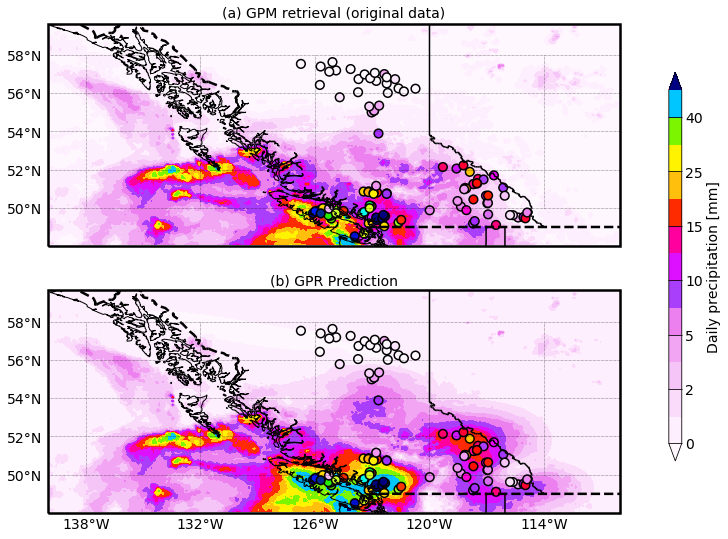

In [101]:
clevel = np.array([0, 1, 2, 3.5, 5, 7.5, 10, 12.5, 15, 20, 25, 30, 40, 60])


fig = plt.figure(figsize=(16*0.75, 12*0.75))
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
#ax3 = plt.subplot(3, 1, 3, projection=ccrs.PlateCarree())
AX = [ax1, ax2]
for ax in AX:
    ax.set_extent([-140, -110, 48, 59], ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=5)
    ax.outline_patch.set_linewidth(2.5)
    
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                 linewidth=0.5, color='k', linestyle=':')
    GL.xlabels_top = False
    GL.ylabels_right = False
    GL.xlabels_bottom = False
    GL.xformatter = LONGITUDE_FORMATTER
    GL.yformatter = LATITUDE_FORMATTER
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.ylocator = mticker.FixedLocator([50, 52, 54, 56, 58])
GL.xlabels_bottom = True

CS1 = ax1.contourf(lon, lat, GPM, clevel, cmap=plt.cm.gist_ncar_r, extend='both')
CS2 = ax2.contourf(lon, lat, GPM+mean, clevel, cmap=plt.cm.gist_ncar_r, extend='both')
#CS3 = ax3.contourf(lon, lat, GPM+mean, clevel, cmap=plt.cm.gist_ncar_r, extend='both')
#fig.colorbar(CS, ax=ax1)
ax1.scatter(stn_lon, stn_lat, c=stn_obs, edgecolor='k', linewidth=1.5, s=75, vmin=clevel[0], vmax=clevel[-1], \
           cmap=plt.cm.gist_ncar_r)
ax2.scatter(stn_lon, stn_lat, c=stn_obs, edgecolor='k', linewidth=1.5, s=75, vmin=clevel[0], vmax=clevel[-1], \
           cmap=plt.cm.gist_ncar_r)
#ax3.scatter(stn_lon, stn_lat, c=stn_obs, edgecolor='k', linewidth=1.5, s=75, vmin=clevel[0], vmax=clevel[-1], \
#           cmap=plt.cm.gist_ncar_r)

ax1.set_title('(a) GPM retrieval (original data)', fontsize=14)
ax2.set_title('(b) GPR Prediction', fontsize=14)
#ax3.set_title('(c) GPR Prediction', fontsize=14)

cax = fig.add_axes([0.9, 0.205, 0.015, 0.6]) 
CBar = plt.colorbar(CS1, cax=cax)  
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=14)
CBar.set_label('Daily precipitation [mm]', fontsize=14)
plt.tight_layout()

fig.savefig('/Users/yingkai/Desktop/GPR_high_quality/fig2.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

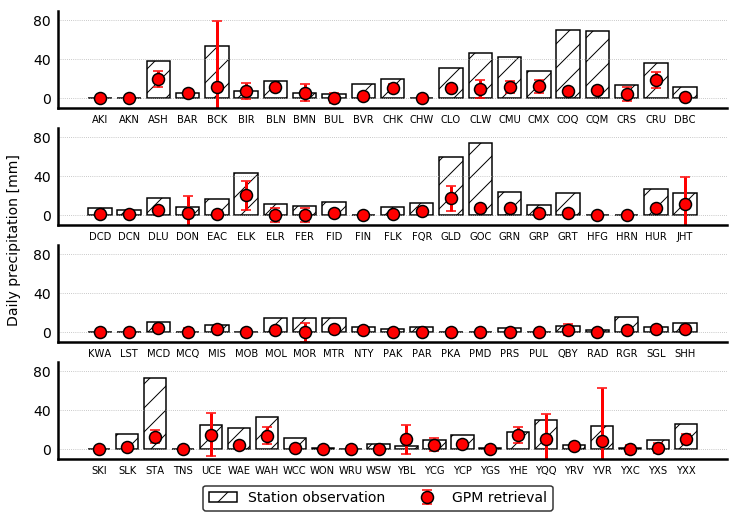

In [102]:
break_id = [21, 42, 63, 85] 

def break_data(data, break_id):
    return data[:break_id[0]], data[break_id[0]:break_id[1]], \
    data[break_id[1]:break_id[2]], data[break_id[2]:break_id[3]]

fake_x = np.arange(len(train_lon))
fake_x_b = break_data(fake_x, break_id)
train_code_b = break_data(train_code, break_id)
train_GPM_b = break_data(train_GPM, break_id)
train_ERROR_b = break_data(train_ERROR, break_id)
train_obs_b = break_data(train_obs, break_id)

fig = plt.figure(figsize=(16*0.75, 11*0.75))
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2)
ax3 = plt.subplot(4, 1, 3)
ax4 = plt.subplot(4, 1, 4)
AX = [ax1, ax2, ax3, ax4]

for i, ax in enumerate(AX):
    ax.grid(linestyle=':'); ax.xaxis.grid(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=14)
    #ax.set_xlabel('False positive rate', fontsize=14)
    #ax.set_ylabel('Rate of ', fontsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=True, left=False, right=False, labelleft=True)

    ax.set_xticks(fake_x_b[i])
    ax.set_xticklabels(train_code_b[i])
    ax.bar(fake_x_b[i], train_obs_b[i], color='w', edgecolor='k', linewidth=1.5, hatch='/', label='Station observation')
    ax.errorbar(fake_x_b[i], train_GPM_b[i], yerr=train_ERROR_b[i], fmt='o', color='r', \
                ms=12, mec='k', capsize=5, elinewidth=3, markeredgewidth=1.5, label='GPM retrieval')
    ax.set_ylim([-10, 90])
    ax.set_yticks([0, 40, 80])
LG = ax4.legend(bbox_to_anchor=(0.75, -0.2), ncol=2, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(1.5)
#ax1.set_title('', fontsize=14, y=0.85)
ax3.text(-0.065, 1.05, 'Daily precipitation [mm]', va='center', ha='center', rotation='90', \
         fontsize=14, transform=ax3.transAxes)

fig.savefig('/Users/yingkai/Desktop/GPR_high_quality/fig1.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [82]:
def cal_verif_stats(stn_assimi, stn_obs):
    # verification stats
    RSME_assim = np.sqrt(mean_squared_error(stn_assimi, stn_obs))
    MAE_assim  = mean_absolute_error(stn_assimi, stn_obs)
    return MAE_assim, RSME_assim

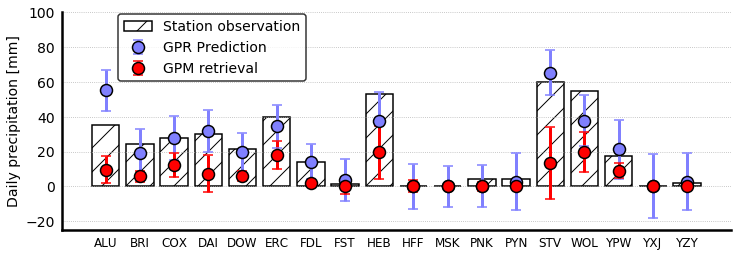

In [103]:
test_mean = (GPM+mean)[test_indx, test_indy]
#test_mean_kg = (GPM+delta_kg)[test_indx, test_indy]
test_ori = (GPM)[test_indx, test_indy]
test_var = np.sqrt((var)[test_indx, test_indy])*1.96
fake_x2 = np.arange(len(test_mean))

fig = plt.figure(figsize=(16*0.75, 4))
ax = fig.gca()

ax.grid(linestyle=':'); ax.xaxis.grid(False)
ax.spines["top"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylabel('Daily precipitation [mm]', fontsize=14)
[j.set_linewidth(2.5) for j in ax.spines.values()]
ax.tick_params(axis="both", which="both", bottom=False, top=False, \
           labelbottom=True, left=False, right=False, labelleft=True)
ax.set_ylim([-25, 100])
ax.bar(fake_x2, test_obs, color='w', edgecolor='k', linewidth=1.5, hatch='/', label='Station observation')
ax.errorbar(fake_x2, test_mean, yerr=test_var, fmt='o', color=B, \
           ms=12, mec='k', capsize=5, elinewidth=3, markeredgewidth=1.5, label='GPR Prediction')
ax.errorbar(fake_x2, test_ori, yerr=test_ERROR, fmt='o', color='r', \
                ms=12, mec='k', capsize=5, elinewidth=3, markeredgewidth=1.5, label='GPM retrieval')
#ax.set_title('Comparisons of GPR prediction and GPM retrievals')
LG = ax.legend(bbox_to_anchor=(0.375, 1.025), prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(1.5)

ax.set_xticks(fake_x2)
ax.set_xticklabels(test_code);

fig.savefig('/Users/yingkai/Desktop/GPR_high_quality/fig3.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

In [104]:
print('GPR bias-corrected:')
cal_verif_stats(test_mean, test_obs)

GPR bias-corrected:


(4.756279625026227, 7.736824988486874)

In [105]:
print('Original:')
cal_verif_stats(test_ori, test_obs)

Original:


(14.810555351773896, 20.098187554712787)